In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as tf_dataloader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 1

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = tf_dataloader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = tf_dataloader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


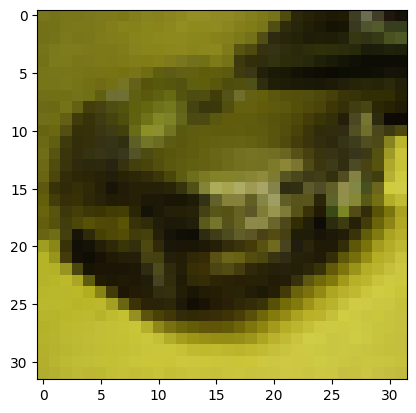

car  


In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 84)
        self.fc3 = nn.Linear(84, 10) # 10 classes for CIFAR-10
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 2 * 2) # Flatten the tensor
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
def hook(module, input, output):
    output_tensors.append(output)

net.fc2.register_forward_hook(hook)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [7]:
epochs = 5
y = []
images = []
for epoch in range(epochs):  # loop over the dataset multiple times
    output_tensors = []
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        if epoch == epochs-1:
            images.append(inputs)
            y.append(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:  # print every 1000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

#torch.save(net.state_dict(), f"cnn_trained_{epochs}_epch.pth")
torch.save(images, "train_images.pth")
torch.save(output_tensors, "train_tensors_v3.pth")
torch.save(y, "train_labels_v3.pth")

print("Finished Training")

[1,  1000] loss: 1.141
[1,  2000] loss: 1.073
[1,  3000] loss: 1.018
[1,  4000] loss: 0.943
[1,  5000] loss: 0.920
[1,  6000] loss: 0.868
[1,  7000] loss: 0.859
[1,  8000] loss: 0.836
[1,  9000] loss: 0.817
[1, 10000] loss: 0.797
[1, 11000] loss: 0.788
[1, 12000] loss: 0.790
[1, 13000] loss: 0.773
[1, 14000] loss: 0.781
[1, 15000] loss: 0.767
[1, 16000] loss: 0.792
[1, 17000] loss: 0.732
[1, 18000] loss: 0.710
[1, 19000] loss: 0.741
[1, 20000] loss: 0.722
[1, 21000] loss: 0.719
[1, 22000] loss: 0.702
[1, 23000] loss: 0.720
[1, 24000] loss: 0.720
[1, 25000] loss: 0.662
[1, 26000] loss: 0.673
[1, 27000] loss: 0.700
[1, 28000] loss: 0.675
[1, 29000] loss: 0.661
[1, 30000] loss: 0.676
[1, 31000] loss: 0.657
[1, 32000] loss: 0.675
[1, 33000] loss: 0.646
[1, 34000] loss: 0.633
[1, 35000] loss: 0.653
[1, 36000] loss: 0.642
[1, 37000] loss: 0.632
[1, 38000] loss: 0.639
[1, 39000] loss: 0.589
[1, 40000] loss: 0.654
[1, 41000] loss: 0.617
[1, 42000] loss: 0.615
[1, 43000] loss: 0.585
[1, 44000] 